# Speech Recognition Tutorial

This notebook shows how to build a model to recognize voice command.

## Virtual environnement 
Creation virtual environnement and install package to use jupyter notebook:
```console
python -m venv env
source ./env/bin/activate
python -m pip install --upgrade pip
pip install ipykernel
python -m ipykernel install --user --name=env
```

Then one the jupyter notebook select the correct kernel.

Once it is created, you should not push the virtual environment to github. With this command, you can add all files execpt some folders :
```console
git add -- . ':!path_to_folder1' ':!path_to_folder2'
```

You can decide to push or not the recorded files in case it is too big.

## Install Dependencies

To use pyaudio on linux, you need build-essential and portaudio2019-dev ubuntu packages so run this command first 
```console
sudo apt install build-essential portaudio19-dev
```

To use pydub, you need ffmpeg ubuntu package, please run this command before installing it :
```console
sudo apt install ffmpeg
```

To use pyttsx2, you need espeak ubuntu package, please run this command before installing it :
```console
sudo apt install espeak
```

To use tensorflow, you need to change packages, please run this command before installing it :
```console
sudo apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
```

In [ ]:
!pip install pydub pyaudio matplotlib pyttsx3 opencv-python opencv-contrib-python threaded seaborn pyqt5 requires.io

In [ ]:
!pip install tensorflow

## Import Packages

In [64]:
import os
from glob import glob
import shutil
import time

import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import numpy as np
import random 

import wave # wav format
import pyaudio # record

import pyttsx3

import cv2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import io

In [2]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Create Folders

In [3]:
DIR_PATH = os.getcwd()

In [4]:
paths = {
    'AUDIO_PATH' : os.path.join(DIR_PATH,'data','audio'),
    'DATA_PATH' : os.path.join(DIR_PATH,'data'),
    'FILES_PATH' : os.path.join(DIR_PATH,'data','audio','files'),
    'LOGS_PATH' : os.path.join(DIR_PATH,'logs'),
    'MODELS_PATH' : os.path.join(DIR_PATH,'data','models'),
    'TEST_PATH' : os.path.join(DIR_PATH,'data','audio','test'),
    'TRAIN_PATH' : os.path.join(DIR_PATH,'data','audio','train'),
}

In [5]:
files = {
    'CAMERA_PY' : os.path.join(DIR_PATH,'camera.py'),
    'FILTER_PY' : os.path.join(DIR_PATH,'filter.py'),
    'RECORD_PY' : os.path.join(DIR_PATH,'record.py'),
}

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

## Defines Labels

In [62]:
labels = ['background','close','pen','phone','stop','track']

In [63]:
keys = ['FILES_PATH','TEST_PATH','TRAIN_PATH']
for key in keys:
    for label in labels:
        path = path = os.path.join(paths[key],label)
        if not os.path.exists(path):
            if os.name == 'posix': # linux machine
                !mkdir -p {path}
            if os.name == 'nt': # windows machine
                !mkdir {path}

## Record Data

With the [record](./record.py) file, you can record data. Each command last 1s. When you run the file, you have to precise the number of file you want to record per label and you can precise the labels you want to record. If not precise, you will record for all the labels.

In [141]:
num = 20
test_size = 0.2

In [142]:
# record file
command_record = f'python {files["RECORD_PY"]} --num {num} --labels background' ## --labels pen stop (to specify labels)

A PYQT5 [application](./filter.py) allows to listen to all the files recorded, to decide to keep or delete it and then to split into test and train folders. 

You have to precise the folder containing the label folders of the audio files to listen. 

You can also precise : 
- test : path to the test folder containing the label folders
- train : path to the train folder containing the label folders
- test_size : the size of the test part to split
- 
If it not precises, you can only delete or keep files.

In [110]:
# pyqt5 application
command_app = f'python {files["FILTER_PY"]} --audio {paths["FILES_PATH"]} --test {paths["TEST_PATH"]} --train {paths["TRAIN_PATH"]} --test_size {test_size}'

In [143]:
print(f'{command_record} && {command_app}')

python /home/alessandrini/Documents/Robot/Ros1/Eden_Robotics/Python/speech/record.py --num 20 --labels background && python /home/alessandrini/Documents/Robot/Ros1/Eden_Robotics/Python/speech/filter.py --audio /home/alessandrini/Documents/Robot/Ros1/Eden_Robotics/Python/speech/data/audio/files --test /home/alessandrini/Documents/Robot/Ros1/Eden_Robotics/Python/speech/data/audio/test --train /home/alessandrini/Documents/Robot/Ros1/Eden_Robotics/Python/speech/data/audio/train --test_size 0.2


## Train Test Repartition

In [196]:
train_labels = os.listdir(paths['TRAIN_PATH'])
train_num_labels = [len(os.listdir(os.path.join(paths['TRAIN_PATH'],label))) for label in train_labels]    

test_labels = os.listdir(paths['TEST_PATH'])
test_num_labels = [len(os.listdir(os.path.join(paths['TEST_PATH'],label))) for label in test_labels]  

In [197]:
def color(array) : 
    data_normalizer = mp.colors.Normalize()
    color_map = mp.colors.LinearSegmentedColormap(
        "my_map",
        {
            "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
            "green": [(0, 0.5, 0.5),
                (1.0, 0, 0)],
            "blue": [(0, 0.50, 0.5),
                (1.0, 0, 0)]
        }
    )
    return color_map(data_normalizer(array))

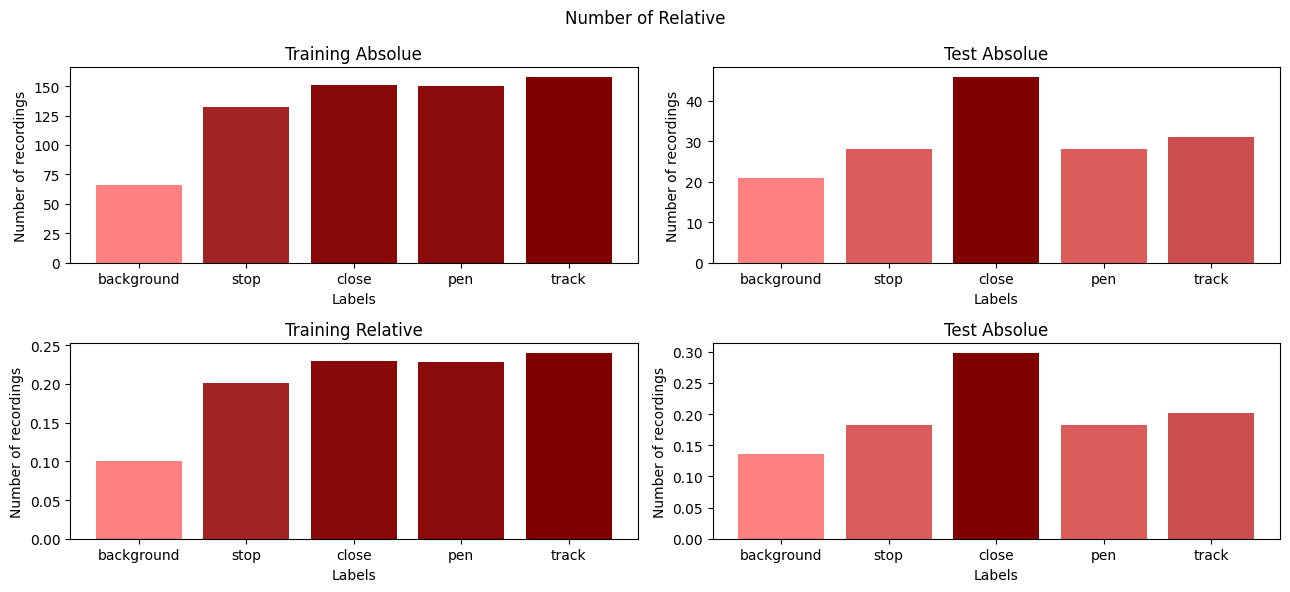

In [198]:
train_labels = os.listdir(paths['TRAIN_PATH'])
train_num_labels = np.array([len(os.listdir(os.path.join(paths['TRAIN_PATH'],label))) for label in train_labels])    

test_labels = os.listdir(paths['TEST_PATH'])
test_num_labels = np.array([len(os.listdir(os.path.join(paths['TEST_PATH'],label))) for label in test_labels])    


fig, axes = plt.subplots(2, 2, figsize=(13, 6))

ax = axes[0][0]
ax.bar(train_labels,train_num_labels,color=color(train_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of recordings')
ax.set_title('Training Absolue')


ax = axes[0][1]
ax.bar(test_labels,test_num_labels,color=color(test_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of recordings')
ax.set_title('Test Absolue')

ax = axes[1][0]
ax.bar(train_labels,train_num_labels/np.sum(train_num_labels),color=color(train_num_labels/np.sum(train_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of recordings')
ax.set_title('Training Relative')


ax = axes[1][1]
ax.bar(test_labels,test_num_labels/np.sum(test_num_labels),color=color(test_num_labels/np.sum(test_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of recordings')
ax.set_title('Test Absolue')
fig.suptitle('Number of Relative')
fig.tight_layout()
plt.show()



## Load test, train, validation

In [199]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=paths['TRAIN_PATH'],
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=paths['TEST_PATH'],
    batch_size=64,
    seed=0,
    output_sequence_length=16000,
    )
    
label_names = np.array(train_ds.class_names)
print(f"label names : {label_names}")


Found 657 files belonging to 5 classes.
Using 526 files for training.
Using 131 files for validation.
Found 154 files belonging to 5 classes.
label names : ['background' 'close' 'pen' 'stop' 'track']


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [200]:
# drop the extra axis cause audio contains only one channel
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [201]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


## Draw wave function

This gives an idea of the representation of the audio

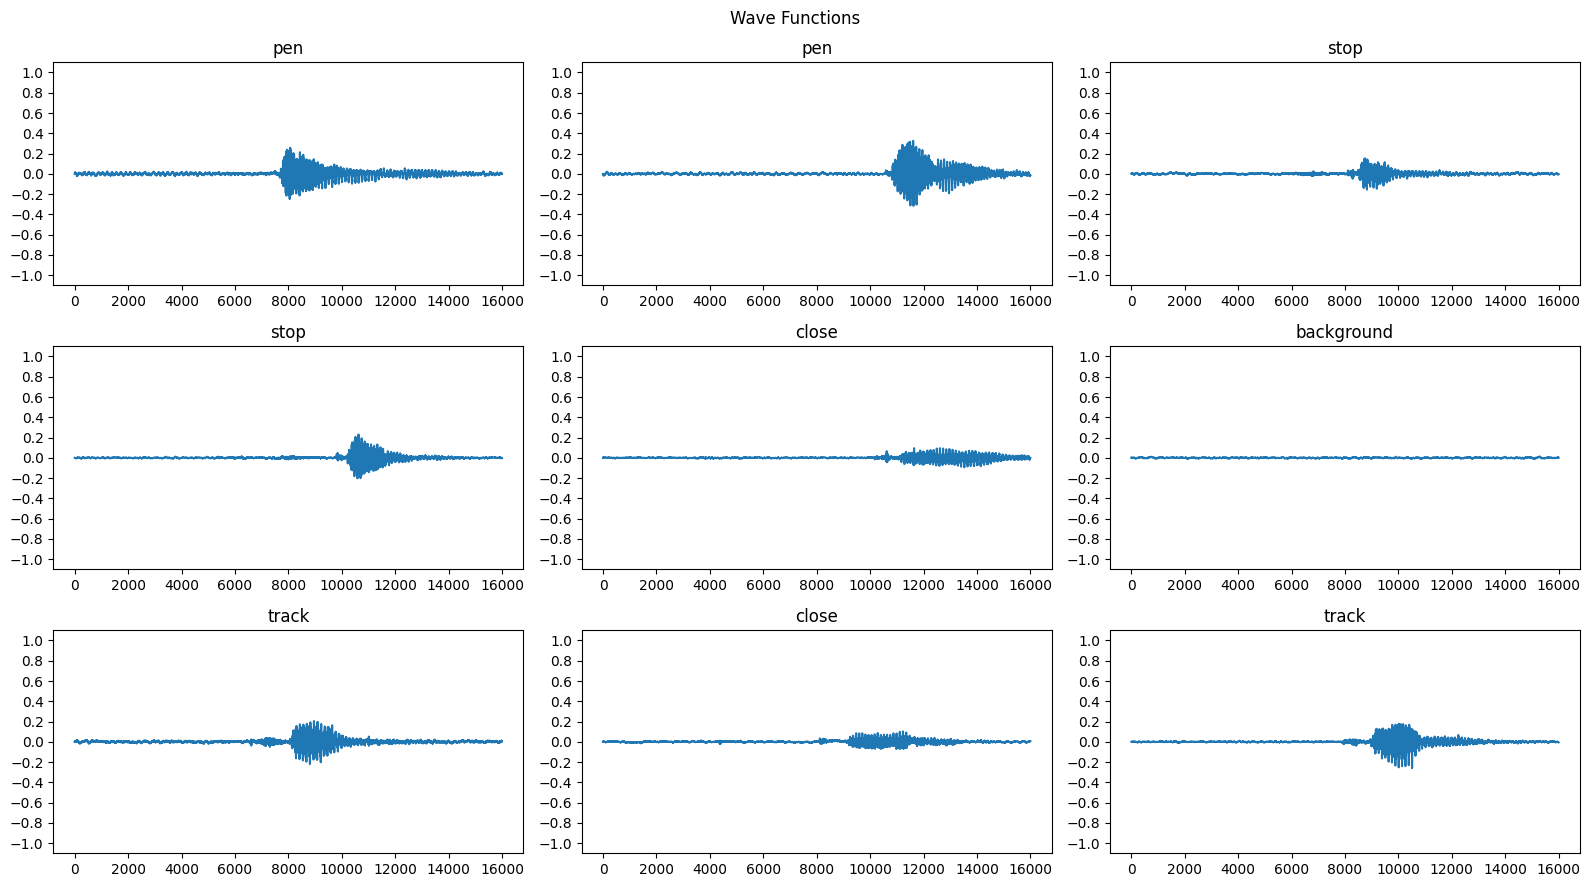

In [202]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])
fig.suptitle('Wave Functions')
fig.tight_layout()
plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [203]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [204]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

## Create Spectrogram Dataset

In [205]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [206]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [207]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

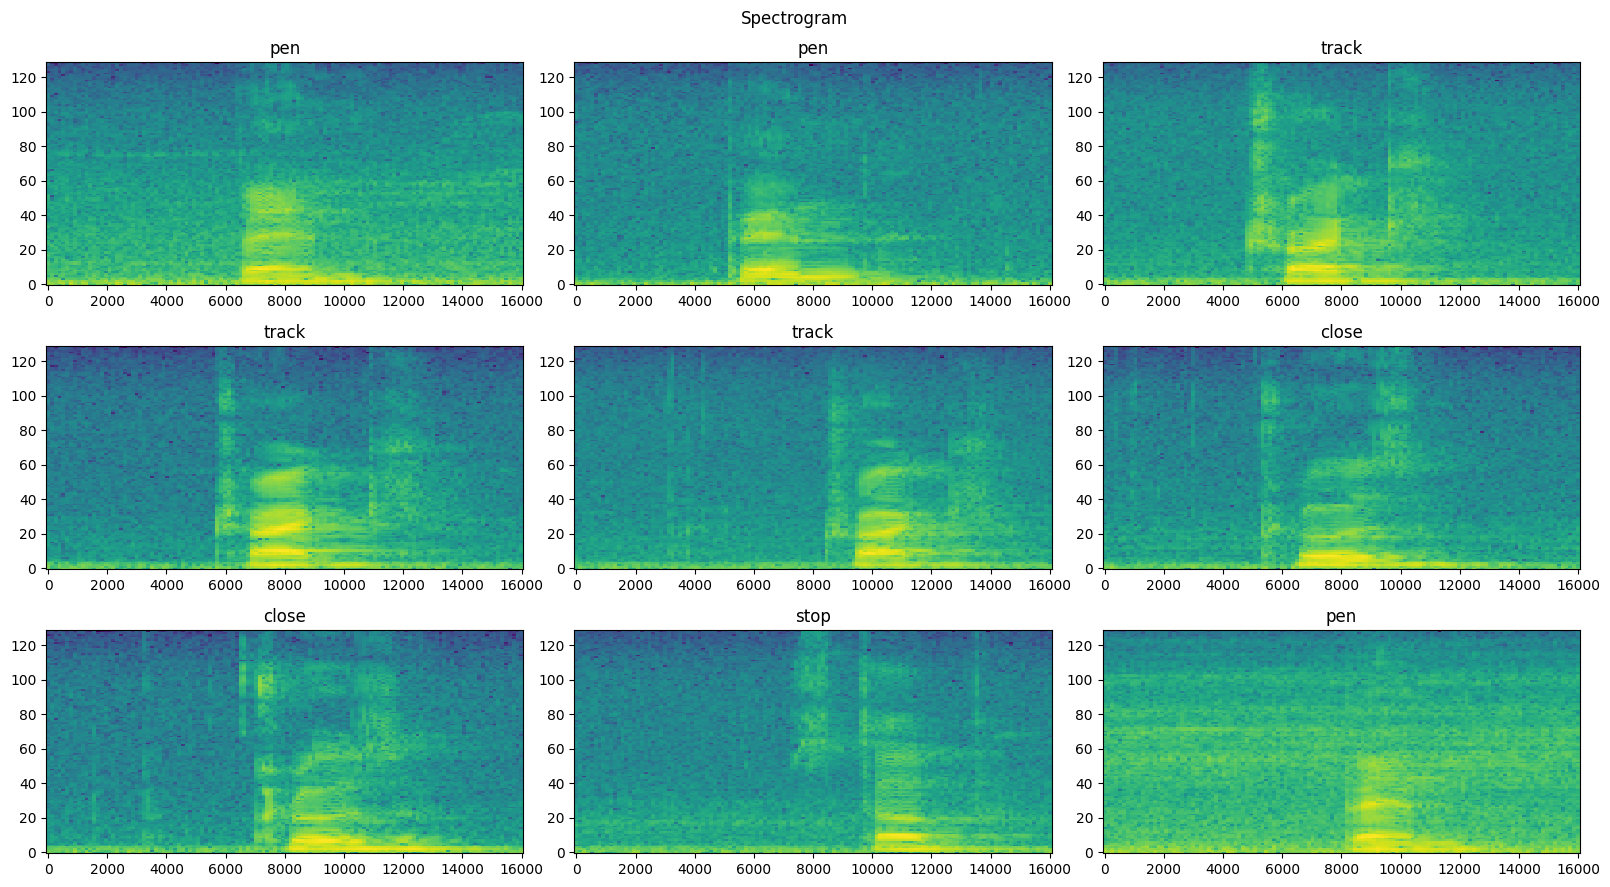

In [208]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

fig.suptitle('Spectrogram')
fig.tight_layout()
plt.show()

## Explore Dataset

Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [209]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: pen
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: pen
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


## Build Model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [210]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [211]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

Input shape: (124, 129, 1)


In [212]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_12 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 14, 14, 64)      

In [213]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Log Functions

In [214]:
model_number = 11
path = os.path.join(paths['LOGS_PATH'],f'model_{model_number}')
if os.path.exists(path):
    print('Model already exists !')
else : 
    log_dir = os.path.join(paths['LOGS_PATH'],f'model_{model_number}')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [215]:
file_writer_cm = tf.summary.create_file_writer(os.path.join(log_dir,'cm'))
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  y_pred = model.predict(val_spectrogram_ds)
  y_pred = tf.argmax(y_pred, axis=1)
  y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

  confusion_mtx = tf.math.confusion_matrix(y_true, y_pred).numpy()
  confusion_normalized = confusion_mtx.astype("float") / confusion_mtx.sum(axis=1)
  
  fig, axes = plt.subplots(1, 2, figsize=(13, 6))
  ax = axes[0]
  sns.heatmap(confusion_mtx,
              xticklabels=label_names,
              yticklabels=label_names,
              annot=True,
              fmt='g',
              ax = ax
          )
  ax.set_xlabel('Prediction')
  ax.set_ylabel('Label')
  ax.set_title('Absolue')
  ax = axes[1]
  sns.heatmap(confusion_normalized,
              xticklabels=label_names,
              yticklabels=label_names,
              annot=True,
              fmt='g',
              ax = ax
          )
  ax.set_xlabel('Prediction')
  ax.set_ylabel('Label')
  ax.set_title('Relative')

  buf = io.BytesIO()
  plt.savefig(buf, format='png')

  plt.close(fig)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=4)

  image = tf.expand_dims(image, 0)
  
  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", image, step=epoch)

    
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [216]:
file_writer_lr = tf.summary.create_file_writer(os.path.join(log_dir,'metrics'))

def lr_schedule(epoch):

    learning_rate = model.optimizer.lr.numpy()
    with file_writer_lr.as_default():
        tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


## Train model

In [217]:
EPOCHS = 50

In [218]:
early_stopping =  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)


Configure the Keras model with the Adam optimizer and the cross-entropy loss: (optimize abd loss can be change)

In [219]:
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping,tensorboard_callback,cm_callback,lr_callback],
)

Epoch 1/50
9/9 [==============================] - 2s 195ms/step - loss: 1.4061 - accuracy: 0.3612 - val_loss: 1.1957 - val_accuracy: 0.4962 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 1s 166ms/step - loss: 0.9309 - accuracy: 0.6635 - val_loss: 0.5984 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 2s 187ms/step - loss: 0.5186 - accuracy: 0.8498 - val_loss: 0.2998 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 1s 165ms/step - loss: 0.3390 - accuracy: 0.9202 - val_loss: 0.2114 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 1s 163ms/step - loss: 0.2408 - accuracy: 0.9278 - val_loss: 0.1278 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 1s 160ms/step - loss: 0.1625 - accuracy: 0.9544 - val_loss: 0.1077 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 1s 165ms/step - loss: 0.1366 - a

Let's plot the training and validation loss curves to check how your model has improved during training:

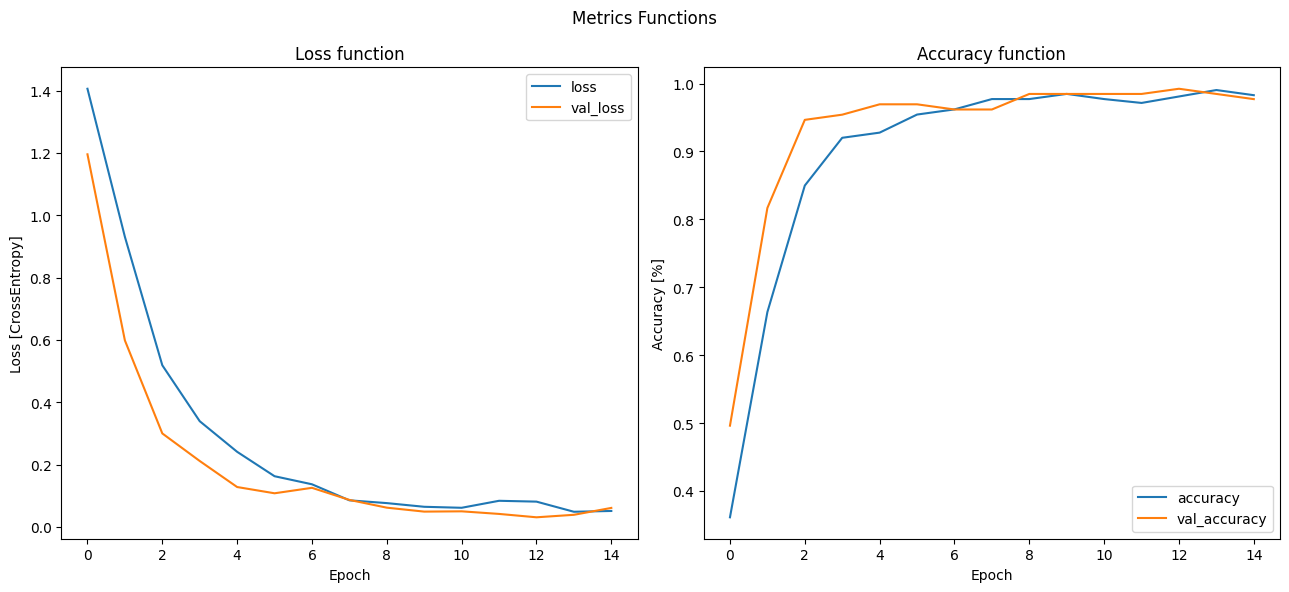

In [220]:
metrics = history.history

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

ax = axes[0]
ax.plot(history.epoch,metrics['loss'],metrics['val_loss'])
ax.legend(['loss', 'val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss [CrossEntropy]')
ax.set_title('Loss function')


ax = axes[1]
ax.plot(history.epoch,metrics['accuracy'],metrics['val_accuracy'])
ax.legend(['accuracy', 'val_accuracy'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy [%]')
ax.set_title('Accuracy function')

fig.suptitle('Metrics Functions')
fig.tight_layout()
plt.show()


In [194]:
!tensorboard --logdir {paths['LOGS_PATH']}

2022-12-29 12:34:38.537697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 12:34:38.724736: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-29 12:34:38.729274: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alessandrini/Documents/Robot/Ros1/Eden_Robotics/Python/speech/env/lib/python3

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [221]:
model.evaluate(
    test_spectrogram_ds, 
    return_dict=True,
)

3/3 [==============================] - 0s 12ms/step - loss: 0.1874 - accuracy: 0.9675


{'loss': 0.18739478290081024, 'accuracy': 0.9675324559211731}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [222]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

3/3 [==============================] - 0s 13ms/step


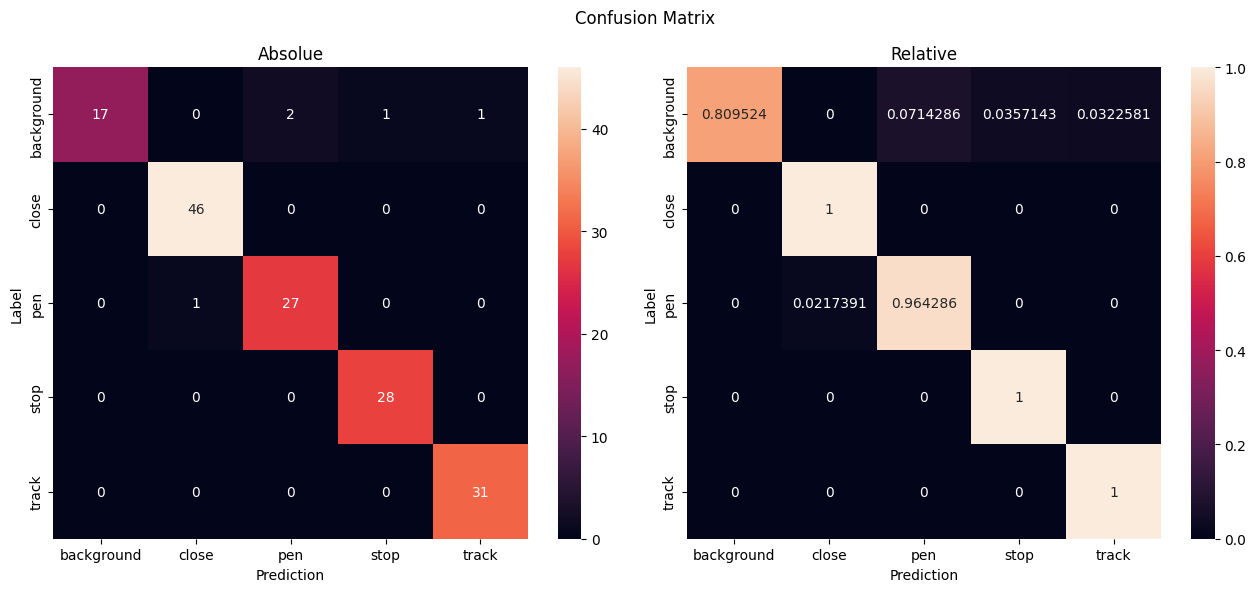

In [223]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred).numpy()
confusion_normalized = confusion_mtx.astype("float") / confusion_mtx.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

ax = axes[0]
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True,
            fmt='g',
            ax = ax
        )
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
ax.set_title('Absolue')


ax = axes[1]
sns.heatmap(confusion_normalized,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True,
            fmt='g',
            ax = ax
        )
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
ax.set_title('Relative')

fig.suptitle('Confusion Matrix')
fig.tight_layout()
plt.show()


## Save Model

In [224]:
model_number = 11
path = os.path.join(paths['MODELS_PATH'],f'model_{model_number}.h5')
if os.path.exists(path):
    print('Model already exists !')

In [225]:
model.save(path)

## Load Model

In [ ]:
model_number = 5
path = os.path.join(paths['MODELS_PATH'],f'model_{model_number}.h5')
if not os.path.exists(path):
    print('Model does not exists !')

In [312]:
model = models.load_model(path)

In [313]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_5 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)       

## Real Time Recoginition

In [314]:
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card


In [319]:
def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    frames = []
    seconds = 1
    for _ in range(int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    stream.stop_stream()
    stream.close()

    return np.frombuffer(b''.join(frames), dtype=np.int16)

def terminate():
    p.terminate()

In [316]:
def preprocess_audiobuffer(waveform):
    """
    waveform: ndarray of size (16000, )
    
    output: Spectogram Tensor of size: (1, `height`, `width`, `channels`)
    """
    #  normalize from [-32768, 32767] to [-1, 1]
    waveform =  waveform / 32768
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    spectogram = get_spectrogram(waveform)
    # add one dimension
    return tf.expand_dims(spectogram, 0)

In [317]:
def predict_mic():
    audio = record_audio()
    spec = preprocess_audiobuffer(audio)
    prediction = model(spec)
    label_pred = np.argmax(prediction, axis=1)
    return label_names[label_pred[0]]


In [320]:
while True:
    label = predict_mic()
    print(f"Predicted label : {label}")
    if label == "stop":
        terminate()
        break
terminate()

Predicted label : background
Predicted label : background
Predicted label : background
Predicted label : stop


## File Recoginition

In [42]:
def read_file(path):
    wav_file = wave.open(path,'rb')
    data = wav_file.readframes(1)
    frames = []
    while data != b'':
        data = wav_file.readframes(1)
        frames.append(data)
    return np.frombuffer(b''.join(frames), dtype=np.int16)

In [43]:
def predict_file(path):
    audio = read_file(path)
    spec = preprocess_audiobuffer(audio)
    prediction = model(spec)
    label_pred = np.argmax(prediction, axis=1)
    return  label_names[label_pred[0]]

In [223]:
label = 'track'
n = 3
file = os.listdir(os.path.join(paths['TEST_PATH'],label))[n]
path = os.path.join(paths['TEST_PATH'],label,file)
label_pred = predict_file(path)
print(f'Predicted label : {label_pred}')
print(f'Real Label : {label}')

Predicted label : track
Real Label : track


## Real Time Webcam And Voice

The [camera](./camera.py) is an example to combine opencv tracking with voice command

You launch the file and you can say : 
- track : to open a window and select an object
- stop :  to stop tracking

This can be improve with object detection model

In [232]:
model_number = 8

In [233]:
!python {files['CAMERA_PY']} --model {model_number}

2022-12-29 12:47:01.026181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 12:47:01.190140: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-29 12:47:01.193189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alessandrini/Documents/Robot/Ros1/Eden_Robotics/Python/speech/env/lib/python3